In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load dataset from local file
# path_to_file = 'heart_disease_uci.csv'  
# data = pd.read_csv(path_to_file)
data = ('../Data/heart_disease_uci.csv')
df = pd.read_csv(data)  
print(df.head())  # Display the first few rows of the dataset


   age     sex    dataset               cp  trestbps   chol    fbs  \
0   63    Male  Cleveland   typical angina     145.0  233.0   True   
1   67    Male  Cleveland     asymptomatic     160.0  286.0  False   
2   67    Male  Cleveland     asymptomatic     120.0  229.0  False   
3   37    Male  Cleveland      non-anginal     130.0  250.0  False   
4   41  Female  Cleveland  atypical angina     130.0  204.0  False   

          restecg  thalch  exang  oldpeak        slope   ca  \
0  lv hypertrophy   150.0  False      2.3  downsloping  0.0   
1  lv hypertrophy   108.0   True      1.5         flat  3.0   
2  lv hypertrophy   129.0   True      2.6         flat  2.0   
3          normal   187.0  False      3.5  downsloping  0.0   
4  lv hypertrophy   172.0  False      1.4    upsloping  0.0   

                thal  num  
0       fixed defect    0  
1             normal    2  
2  reversable defect    1  
3             normal    0  
4             normal    0  


/Users/ossaiemmanuelchekwube/Documents/BINF-5507-Materials/.pixi/envs/default/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.454e+06, tolerance: 8.692e+02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/Users/ossaiemmanuelchekwube/Documents/BINF-5507-Materials/.pixi/envs/default/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.686e+03, tolerance: 8.692e+02
  model = cd_fast.enet_coo

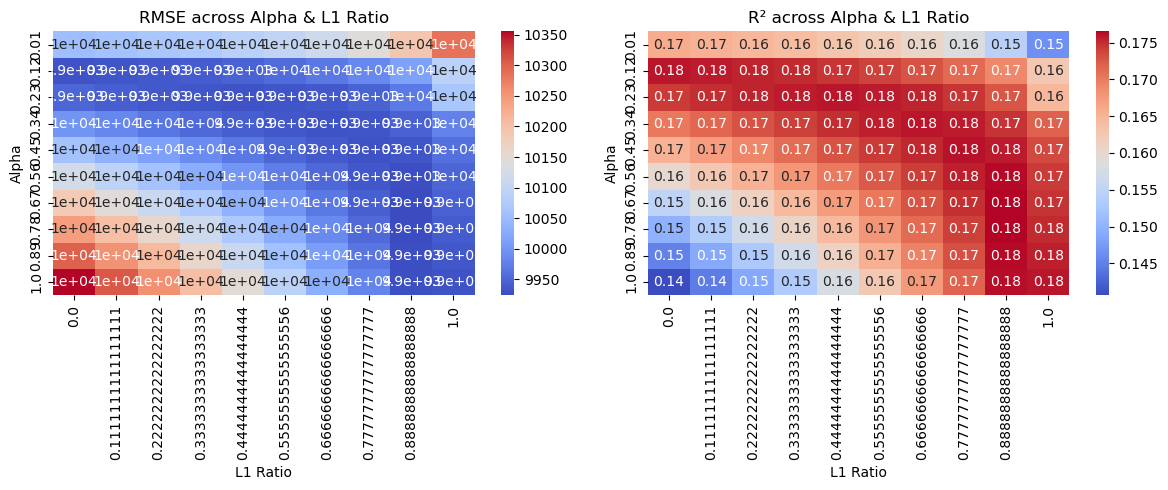

Best Configuration: Alpha=0.67, L1 Ratio=0.8888888888888888, MSE=9923.4074, R²=0.1765


In [2]:
df_copy = df.copy()

# Fill missing values only for numeric columns
numeric_cols = df_copy.select_dtypes(include=["number"]).columns
df_copy[numeric_cols] = df_copy[numeric_cols].apply(lambda col: col.fillna(col.mean()))

# Remove duplicate rows
df_copy = df_copy.drop_duplicates()

# Convert categorical columns using one-hot encoding
categorical_cols = ["sex", "cp", "restecg", "thal", "slope"]
df_copy[categorical_cols] = df_copy[categorical_cols].fillna("Unknown")  # Before encoding
df_encoded = pd.get_dummies(df_copy, columns=categorical_cols, drop_first=True)

# Remove 'dataset' column and fill missing numeric values
df_encoded = df_encoded.drop(columns=['dataset'])
df_encoded = df_encoded.fillna(df_encoded.mean())  # Fill numeric NaNs

# Select relevant features and target variable
X = df_encoded.drop(columns=["chol"])  # Exclude target column
y = df_encoded["chol"]  # Target variable

# # Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define range of hyperparameters
alpha_values = np.linspace(0.01, 1.0, 10)  # Regularization strength
l1_ratios = np.linspace(0, 1, 10)  # Balance between L1 and L2 penalties

# Store results
results = []
for alpha in alpha_values:
    for l1_ratio in l1_ratios:
        model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        results.append([alpha, l1_ratio, mse, r2])

# Convert results to DataFrame
df_results = pd.DataFrame(results, columns=["alpha", "l1_ratio", "MSE", "R2"])

# Pivot DataFrame for heatmap visualization
pivot_mse = df_results.pivot(index="alpha", columns="l1_ratio", values="MSE")
pivot_r2 = df_results.pivot(index="alpha", columns="l1_ratio", values="R2")

# Plot heatmaps
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(pivot_mse, annot=True, cmap="coolwarm", ax=axes[0])
axes[0].set_title("RMSE across Alpha & L1 Ratio")
axes[0].set_xlabel("L1 Ratio")
axes[0].set_ylabel("Alpha")

sns.heatmap(pivot_r2, annot=True, cmap="coolwarm", ax=axes[1])
axes[1].set_title("R² across Alpha & L1 Ratio")
axes[1].set_xlabel("L1 Ratio")
axes[1].set_ylabel("Alpha")

plt.tight_layout()
plt.show()

# Identify top-performing configuration
best_config = df_results.loc[df_results["R2"].idxmax()]
print(f"Best Configuration: Alpha={best_config['alpha']}, L1 Ratio={best_config['l1_ratio']}, MSE={best_config['MSE']:.4f}, R²={best_config['R2']:.4f}")


In [3]:
# Prepare the Data for Logistic Regression
X = df_encoded.drop(columns=["num"])  # Exclude target column
y = (df_encoded["num"] > 0).astype(int)  # Target variable (binary: 0 = no disease, 1 = disease)
print(y.value_counts())  # Check class distribution

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#split Data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train logistic regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Initialize and train model
log_reg = LogisticRegression(penalty="l2", solver="lbfgs", random_state=42)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]  # Get probability scores

# Evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_prob)

print(f"Logistic Regression - Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, AUROC: {auroc:.4f}")

num
1    508
0    410
Name: count, dtype: int64
Logistic Regression - Accuracy: 0.8098, F1-score: 0.8387, AUROC: 0.8837


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Test different values of k
neighbors = [1, 5, 10]
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k) # Initialize k-NN classifier with k neighbors
    knn.fit(X_train, y_train) # Train the model
    
    # Make predictions
    y_pred = knn.predict(X_test) # Predict class labels
    y_pred_prob = knn.predict_proba(X_test)[:, 1]# Get probability scores for the positive class
    
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auroc = roc_auc_score(y_test, y_pred_prob)

    print(f"k-NN (k={k}) - Accuracy: {accuracy:.4f}, F1-score: {f1:.4f}, AUROC: {auroc:.4f}")


k-NN (k=1) - Accuracy: 0.7337, F1-score: 0.7721, AUROC: 0.7300
k-NN (k=5) - Accuracy: 0.8098, F1-score: 0.8387, AUROC: 0.8685
k-NN (k=10) - Accuracy: 0.8043, F1-score: 0.8364, AUROC: 0.8694


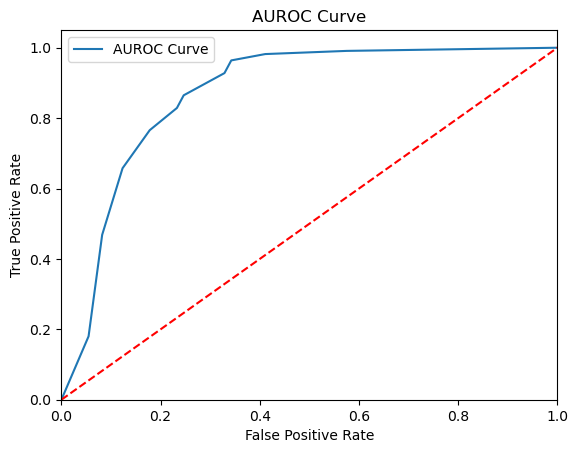

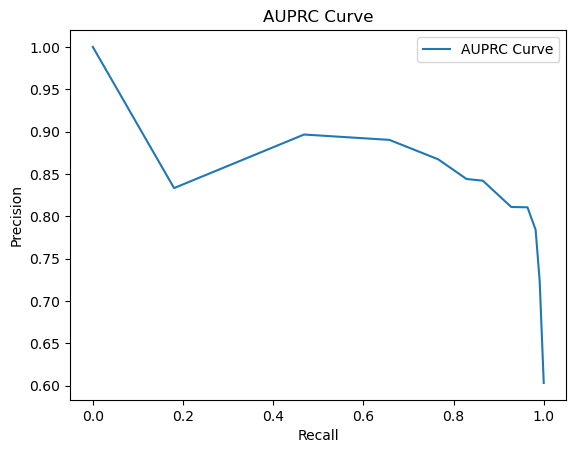

In [5]:
from sklearn.metrics import roc_curve, precision_recall_curve

# AUROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob) # Calculate false positive rate and true positive rate
plt.plot(fpr, tpr, label="AUROC Curve")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random classifier])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("AUROC Curve")
plt.legend()
plt.show()

# AUPRC Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
plt.plot(recall, precision, label="AUPRC Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("AUPRC Curve")
plt.legend()
plt.show()